**UNR - TUIA**

# Trabajo Prático N°: 2 - Aprendizaje Automático

### Integrantes:
*   Crenna, Giuliano. Legajo: C-7438/1.
*   Pace, Bruno. Legajo: P-5295/7.
*   Sancho Almenar, Mariano. Legajo: S-5778/9.

Chequeo si estoy en google colab o no, por una cuestión de prolijidad del código y evitar modificaciones continuas dependiendo el entorno de ejecución.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
  !pip install -r requirements.txt

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached pyod-2.0.2-py3-none-any.whl
  Using cached category_encoders-2.6.4-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached matplotlib-3.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached plotly_resampler-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached sktime-0.26.0-py3-none-any.whl.metadata (29 kB)
  Using cached tbats-1.1.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached dash-2.18.2-py3-none-any.whl.metadata (10 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
Using cached sktime-0.26.0-py3-none-any.whl (21.8 MB)
Using cached matpl

In [124]:
#Tratamiento de datos:
import numpy as np
import pandas as pd
import math

#Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocesado y modelado:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, make_scorer, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from pycaret.classification import *
from imblearn.over_sampling import ADASYN
import tensorflow as tf
import shap
import random

from typing import Dict, List, Tuple, Any
import os

#Configuración de warnings:
import warnings
warnings.filterwarnings('ignore')

# Ignore UserWarning related to 'penalty=None' and ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
DATASET_PATH: str = os.path.join(os.getcwd(), 'data', 'weatherAUS.csv')

In [4]:
df_pure: pd.DataFrame = pd.read_csv(DATASET_PATH)
df: pd.DataFrame = df_pure.copy()

# EDA

Se elige una semilla para que sean siempre las mismas 10 ciudades.

In [5]:
random.seed(42)
choosen_cities: List[str] = random.sample(df['Location'].unique().tolist(), k=10)

In [6]:
df: pd.DataFrame = df[df['Location'].isin(choosen_cities)].reset_index(drop = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30818 non-null  object 
 1   Location       30818 non-null  object 
 2   MinTemp        30254 non-null  float64
 3   MaxTemp        30421 non-null  float64
 4   Rainfall       30243 non-null  float64
 5   Evaporation    10686 non-null  float64
 6   Sunshine       10127 non-null  float64
 7   WindGustDir    26779 non-null  object 
 8   WindGustSpeed  26797 non-null  float64
 9   WindDir9am     27071 non-null  object 
 10  WindDir3pm     28746 non-null  object 
 11  WindSpeed9am   29921 non-null  float64
 12  WindSpeed3pm   29269 non-null  float64
 13  Humidity9am    29837 non-null  float64
 14  Humidity3pm    29348 non-null  float64
 15  Pressure9am    21206 non-null  float64
 16  Pressure3pm    21250 non-null  float64
 17  Cloud9am       15523 non-null  float64
 18  Cloud3

### Descripción de Variables

1. *Date*: Fecha de la medición.
2. *Location*: Lugar donde se tomaron las mediciones.
3. *MinTemp*: Temperatura mínima del día.
4. *MaxTemp*: Temperatura máxima del día.
5. *Rainfall*: Cantidad de lluvia registrada (en mm).
6. *Evaporation*: Cantidad de agua evaporada (en mm).
7. *Sunshine*: Horas de luz solar en el día.
8. *WindGustDir*: Dirección del viento más fuerte del día.
9. *WindGustSpeed*: Velocidad del viento más fuerte (en km/h).
10. *WindDir9am*: Dirección del viento a las 9 AM.
11. *WindDir3pm*: Dirección del viento a las 3 PM.
12. *WindSpeed9am*: Velocidad del viento a las 9 AM (en km/h).
13. *WindSpeed3pm*: Velocidad del viento a las 3 PM (en km/h).
14. *Humidity9am*: Humedad relativa a las 9 AM.
15. *Humidity3pm*: Humedad relativa a las 3 PM.
16. *Pressure9am*: Presión atmosférica a las 9 AM.
17. *Pressure3pm*: Presión atmosférica a las 3 PM.
18. *Cloud9am*: Cobertura nubosa a las 9 AM.
19. *Cloud3pm*: Cobertura nubosa a las 3 PM.
20. *Temp9am*: Temperatura a las 9 AM.
21. *Temp3pm*: Temperatura a las 3 PM.
22. *RainToday*: Indica si llovió el día de la medición (Sí/No).
23. *RainTomorrow*: Indica si lloverá el día siguiente (Sí/No).

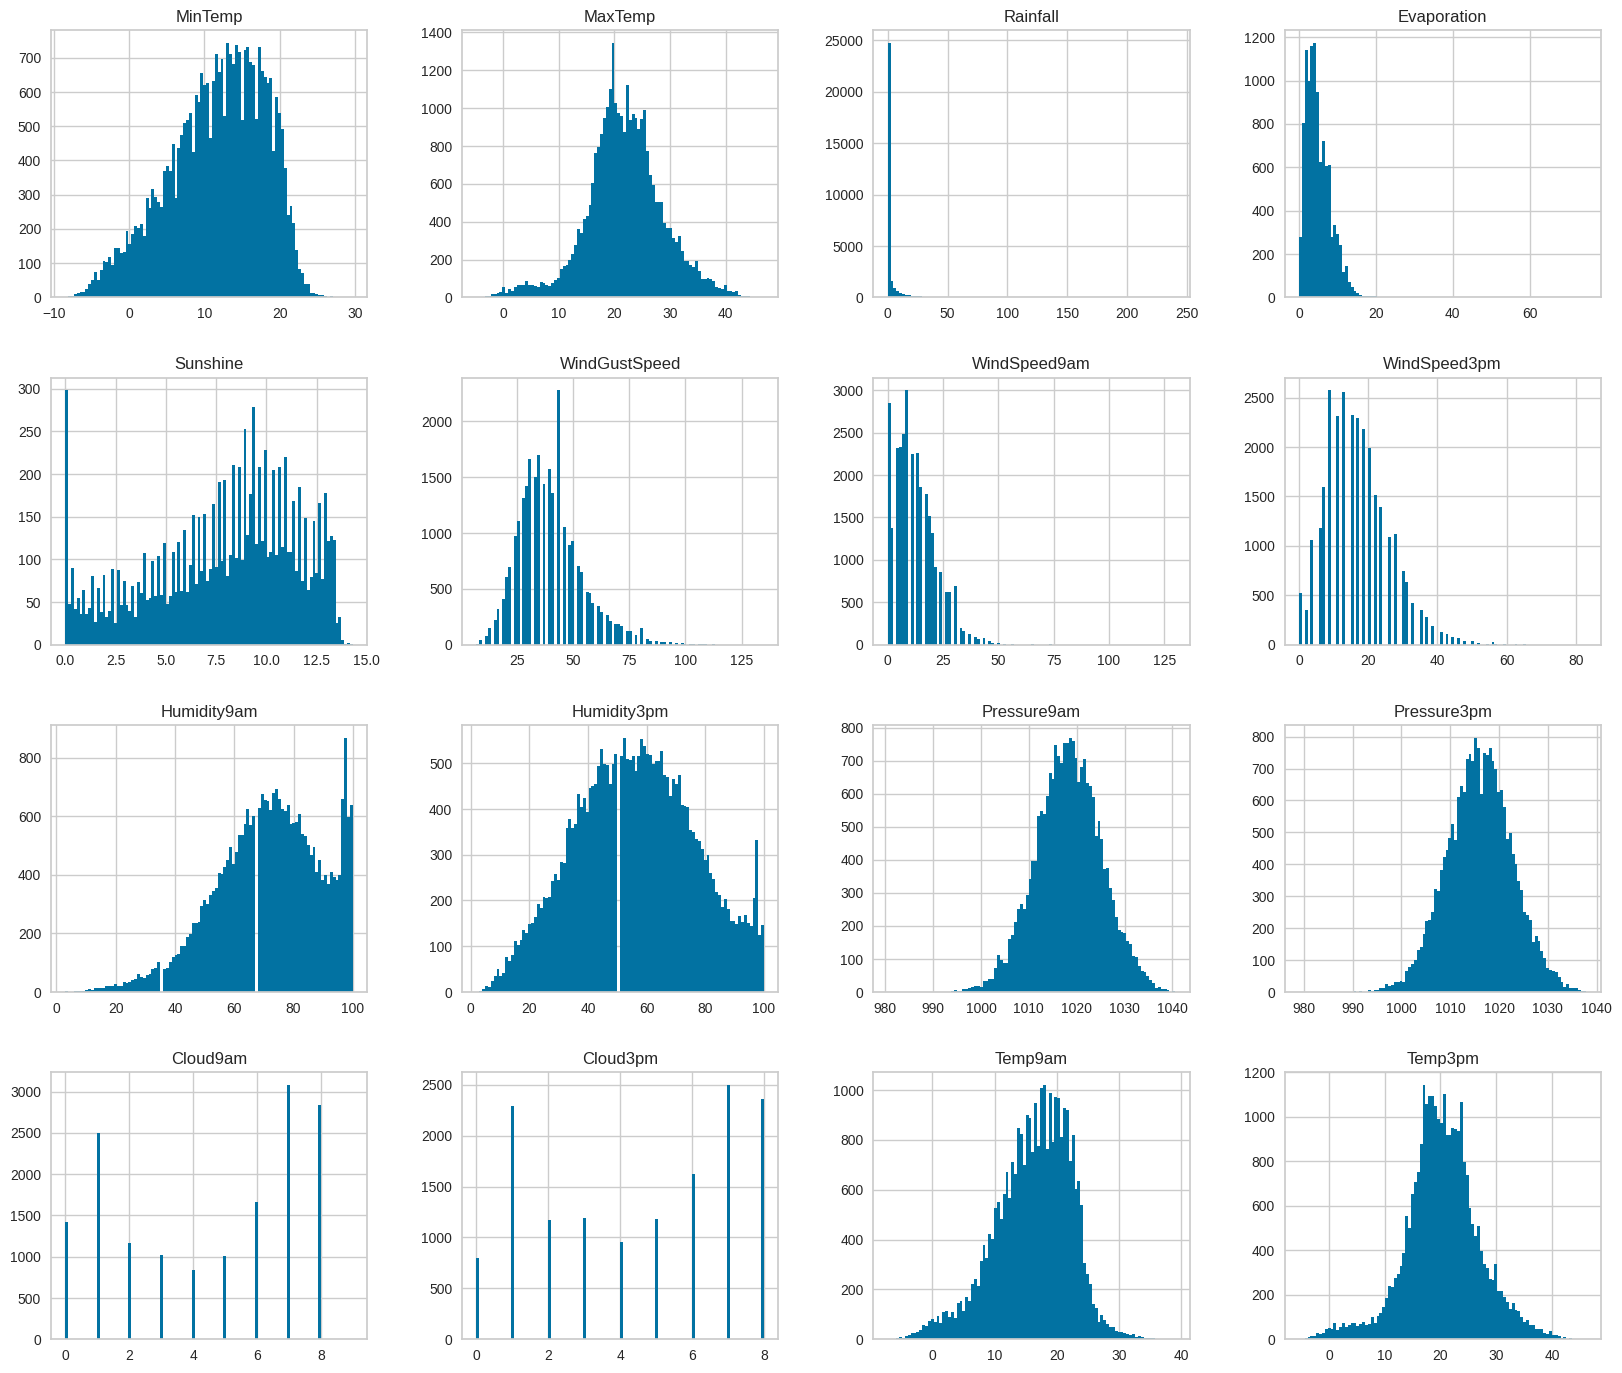

In [8]:
df.hist(figsize= (20,17), bins=100);

La mayoria de las variables presentan distribuciones normales, exceptuando:

- *Rainfall*, *Evaporation*, *WindSpeed3pm*, *Windspeed9am*, *WindGustSpeed* presentan una distribucion asimetrica a la derecha

**Preprocesado:**
1. Convertimos la variable Date a tipo datetime.

In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### Series temporales
Es importante observar cómo las temperaturas y precipitaciones varían con el tiempo.

Como podemos observar las series de tiempo de las temperaturas mínimas y máximas son estrictamente estacionales. Mientras que las precipitaciones no presentan estacionalidad.

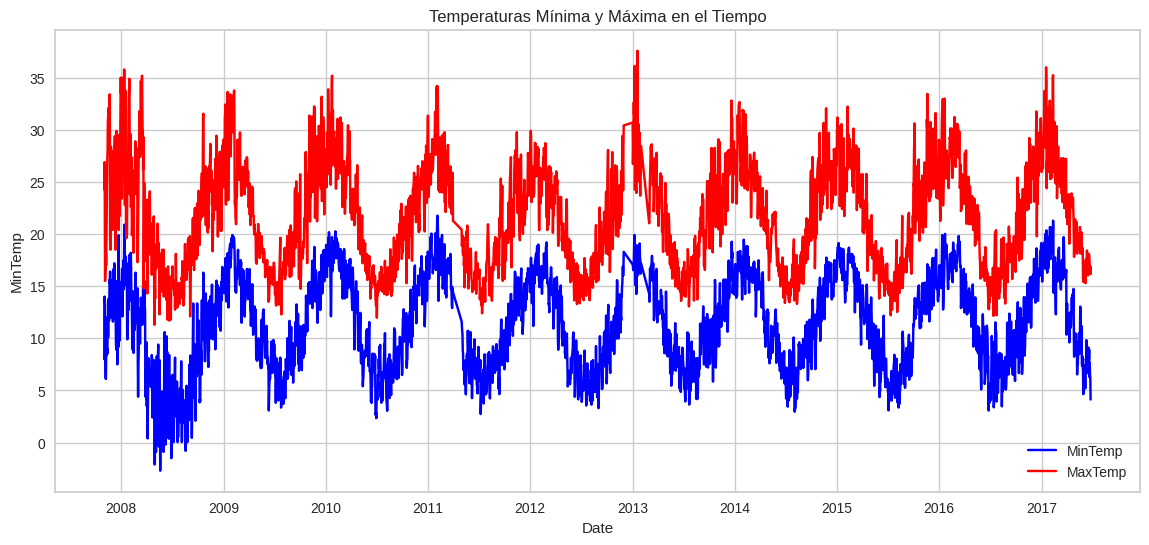

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='MinTemp', data=df, label='MinTemp', color='blue', ci=None)
sns.lineplot(x='Date', y='MaxTemp', data=df, label='MaxTemp', color='red', ci=None)
plt.title("Temperaturas Mínima y Máxima en el Tiempo")
plt.show()

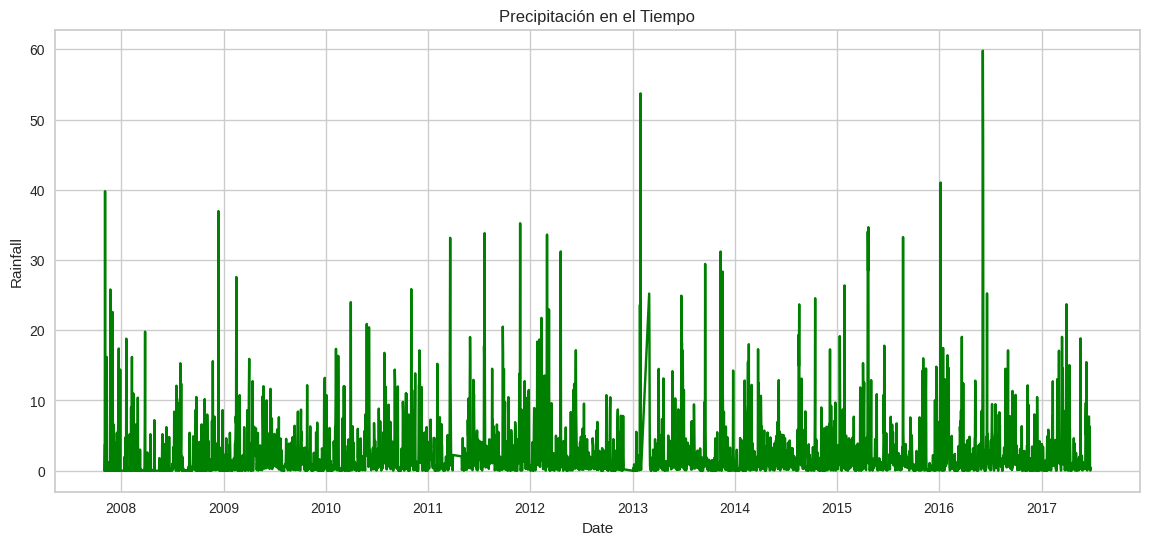

In [11]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Rainfall', data=df, color='green', ci=None)
plt.title("Precipitación en el Tiempo")
plt.show()


### Date

Dado que 'Date' se encuentra con formato 'YYYY-MM-DD', se dividirá en 2 columnas distintas.

- **Year**: Será una variable categórica indicando el año, luego se codificará utilizando One-Hot Encoder.
- **Season**:  Indicará en qué temporada del año ocurrió la medición.

In [12]:
df['Year'] = df['Date'].dt.year

df['Day'] = df['Date'].dt.dayofyear

In [13]:
df[['Date', 'Year', 'Day']].sample(2)

,Date,Year,Day
24138,2016-03-05,2016,65
14754,2016-07-15,2016,197


In [14]:
df.drop(columns= 'Date', inplace=True)


### Mediciones del viento

Las columnas *WindGustDir*, *WindDir9am*, *WindDir3pm*, *WindSpeed3pm* indican la dirección del viento utilizando las direcciones cardinales.

Se transformarán dichas direcciones en las proyecciones que tienen sobre los ejes x e y.

In [15]:
def angle_to_xy(angle: float) -> Tuple[np.float64, np.float64]:
    """
    Función que recibe la dirección del viento en grados y la transformará en projecciones sobre el eje x e y,
    obteniendo así dos valores numéricos por cada columna.
    """

    if math.isnan(angle):
        return (np.nan, np.nan)

    # Convertimos el ángulo a radianes
    angle_rad = math.radians(angle)


    x = math.sin(angle_rad)
    y = math.cos(angle_rad)

    return (x, y)

In [16]:
direction_angles: dict[str, float] = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
}

columnas_viento: List[str] = ['WindDir3pm','WindDir9am', 'WindGustDir']

for columna in columnas_viento:
    df[columna] = df[columna].map(direction_angles)

# Creamos las columnas con las projecciones x e y para los distintos vientos.
df[['WindDir3pm_x', 'WindDir3pm_y']] = df['WindDir3pm'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindDir9am_x', 'WindDir9am_y']] = df['WindDir9am'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindGustDir_x', 'WindGustDir_y']] = df['WindGustDir'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

In [17]:
df.drop(columns=columnas_viento , inplace=True)


### Columnas categóricas Yes/No

Se remplazan por valores 1 y 0

In [18]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

### Location

Para la localidad, se remplaza su valor con su respectiva coordenada


In [19]:
chosen_cities_coordinates: Dict [str, Dict[str, float]] = {
    "Newcastle": {"latitude": -32.9282, "longitude": 151.7817},
    "BadgerysCreek": {"latitude": -33.8836, "longitude": 150.7386},
    "Penrith": {"latitude": -33.7532, "longitude": 150.6880},
    "Perth": {"latitude": -31.9505, "longitude": 115.8605},
    "Canberra": {"latitude": -35.2809, "longitude": 149.1300},
    "Wollongong": {"latitude": -34.4278, "longitude": 150.8931},
    "Nuriootpa": {"latitude": -34.4658, "longitude": 138.9784},
    "NorahHead": {"latitude": -33.2886, "longitude": 151.6154},
    "NorfolkIsland": {"latitude": -29.0408, "longitude": 167.9547},
    "MountGinini": {"latitude": -35.4622, "longitude": 148.9525}
}


In [20]:
coords_df: pd.DataFrame = pd.DataFrame.from_dict(chosen_cities_coordinates, orient='index')
coords_df.reset_index(inplace=True)
coords_df.rename(columns={'index':'Location'}, inplace=True)
coords_df

,Location,latitude,longitude
0,Newcastle,-32.9282,151.7817
1,BadgerysCreek,-33.8836,150.7386
2,Penrith,-33.7532,150.6880
3,Perth,-31.9505,115.8605
4,Canberra,-35.2809,149.1300
5,Wollongong,-34.4278,150.8931
6,Nuriootpa,-34.4658,138.9784
7,NorahHead,-33.2886,151.6154
8,NorfolkIsland,-29.0408,167.9547
9,MountGinini,-35.4622,148.9525


In [21]:
df: pd.DataFrame = df.merge(coords_df, on='Location', how='left')
df: pd.DataFrame = df.drop(columns=['Location'])

In [22]:
df[['Year', 'Day', 'latitude', 'longitude', 'WindDir3pm_x', 'WindDir3pm_y', 'WindDir9am_x', 'WindDir9am_y','WindGustDir_x', 'WindGustDir_y' ,  'RainToday', 'RainTomorrow']].sample(3)

,Year,Day,latitude,longitude,WindDir3pm_x,WindDir3pm_y,WindDir9am_x,WindDir9am_y,WindGustDir_x,WindGustDir_y,RainToday,RainTomorrow
1728,2013,357,-33.8836,150.7386,0.000000,1.00000,1.000000,6.123234e-17,0.382683,-0.923880,0.0,0.0
17028,2014,161,-34.4278,150.8931,-0.382683,-0.92388,-1.000000,-1.836970e-16,0.707107,-0.707107,1.0,1.0
23333,2013,355,-35.4622,148.9525,0.382683,0.92388,-0.382683,9.238795e-01,-0.382683,0.923880,0.0,0.0


# ETL


## Division del conjunto

Separación test y train conforme a las convenciones del 80% para Train y 20% para test. Se guarda un dataset de validación del 10% del sobrante.

In [23]:
X: pd.DataFrame = df.drop(columns='RainTomorrow')
y: pd.DataFrame = df[['RainTomorrow']] #Variable a predecir

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42
)

## Tratamiento de outliers

Se calculan las variables que tienen valores por encima del quantil 0.99 y por debajo de 0.01. Si tienen, se imputa por la mediana.

In [25]:
def reimpute_outliers(df: pd.DataFrame):
    for column in df.columns:
        if column == 'RainToday':
            continue

        lower_bound: float = df[column].quantile(0.01)
        upper_bound: float = df[column].quantile(0.99)
        median_value: float = df[column].median()

        df[column] = df[column].where((df[column] > lower_bound) & (df[column] < upper_bound), median_value)

    return df

X_train = reimpute_outliers(X_train)

## Eliminiación de valores faltantes y_train

In [26]:
y_train.isna().sum()

,0
RainTomorrow,408


y_train presenta 22188 datos, de los cuales 408 son datos faltantes.

Esto representa aproximadamente 1.8% del dataset. Por eso se decide dropearlos.

In [27]:
X_train.reset_index(inplace=True)
y_train.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_train.dropna().index

Se filtran los mismos indices válidos en ambos conjuntos de train

In [28]:
X_train: pd.DataFrame = X_train.iloc[indices_validos]
y_train: pd.Series = y_train.iloc[indices_validos]

In [29]:
y_train.isna().sum()

,0
index,0
RainTomorrow,0


In [30]:
#Eliminación de columnas indices
X_train = X_train.drop(columns=['index'])
y_train = y_train.drop(columns=['index'])

## Eliminación de faltantes de y_test

Se dropean los valores nulos de y_test y X_test con los mismo indices. Ya que representan un 2% del total. Se tomó esta decisión porque, de tener valores nulos, genera conflicto con la matriz de confusión.

Lo que pretende hacer la matriz de confusión es intentar determinar en qué lugar están los valores nan y como no puede, falla.

In [31]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6164 entries, 19140 to 25213
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  6040 non-null   float64
dtypes: float64(1)
memory usage: 96.3 KB


In [32]:
X_test.reset_index(inplace=True)
y_test.reset_index(inplace=True)

# Se almacenan los indices cuyos valores no son Nan
indices_validos: pd.Index = y_test.dropna().index

In [33]:
X_test: pd.DataFrame = X_test.iloc[indices_validos]
y_test: pd.Series = y_test.iloc[indices_validos]

In [34]:
# Eliminación de columnas indices
X_test = X_test.drop(columns=['index'])
y_test = y_test.drop(columns=['index'])

## Análisis de valores duplicados en X_train

Análisis duplicados en X_train. No se realiza con y_train ya que son 0 y 1 y daría duplicados.

In [35]:
X_train.duplicated().sum()

0

No se encuentran valores duplicados.

## Imputación de valores faltantes en X_train y X_test

Se realiza la imputación por medio de KNN.

In [36]:
knn = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)

## Balanceo de Y_train

In [37]:
y_train.value_counts()

,count
RainTomorrow,
0.0,16697
1.0,5083


Se presenta un desbalance en el dataframe y_train, predominando ampliamente los días que no llueven.

In [38]:
print(f'Los días de lluvia del dataset y_train representan el {round(5083*100/y_train.shape[0],2)}%')

Los días de lluvia del dataset y_train representan el 23.34%


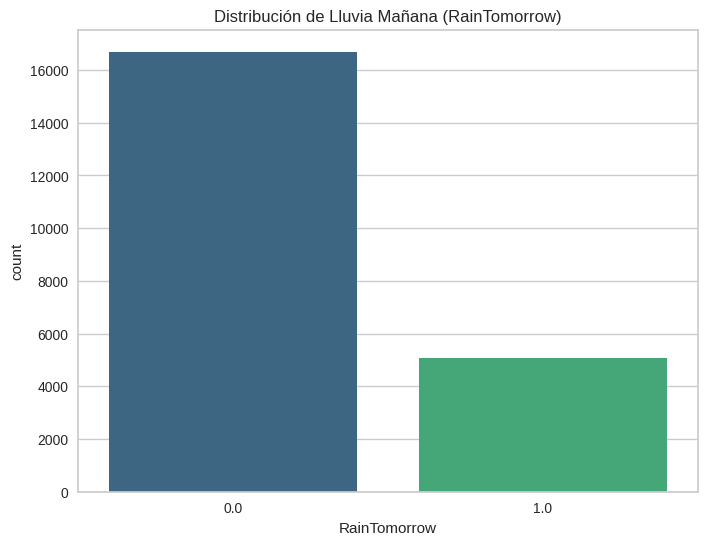

In [39]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=y_train, palette='viridis')
plt.title("Distribución de Lluvia Mañana (RainTomorrow)")
plt.show()



## Estandarizado

Se estanadariza usando Z-Score

In [40]:
scaler: StandardScaler = StandardScaler()

In [127]:
# Se estandariza sin tener en cuenta la columna categórica 'Year'

X_train_std: pd.DataFrame = pd.DataFrame(scaler.fit_transform(X_train.drop('Year', axis = 1)), columns = X_train.drop('Year', axis = 1).columns)
X_test_std: pd.DataFrame = pd.DataFrame(scaler.fit_transform(X_test.drop('Year', axis = 1)), columns = X_test.drop('Year', axis = 1).columns)
X_valid_std: pd.DataFrame = pd.DataFrame(scaler.fit_transform(X_valid.drop('Year', axis = 1)), columns = X_valid.drop('Year', axis = 1).columns)


## Codificación de Year
Usaremos one-hot encoding para el manejo de la columna *Year*. Luego, se agrega las columnas al DataFrame ya estandarizado.

In [42]:
encoder: OneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

In [43]:
X_train_enc = encoder.fit_transform(X_train[['Year']].astype(np.int32))
X_test_enc = encoder.transform(X_test[['Year']].astype(np.int32))

In [44]:
X_train_std = pd.concat([X_train_std, X_train_enc], axis=1)
X_test_std = pd.concat([X_test_std, X_test_enc], axis=1)

In [45]:
X_train_std

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,latitude,longitude,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016
0,0.140583,-0.015138,-0.367578,-0.119518,0.085095,-0.900530,-1.472932,0.243485,0.389509,0.711338,...,0.560501,0.620303,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.749708,0.501141,2.532743,-0.119518,0.085095,-0.167989,-1.200661,-0.245066,0.327187,0.819211,...,0.964803,0.667199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.331471,-0.031272,-0.367578,-0.119518,0.085095,-1.388890,-0.247713,-1.588583,-0.171388,-1.176446,...,-0.106980,0.373050,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.925387,-0.257144,-0.367578,-0.119518,0.085095,-1.633071,-0.247713,-0.977894,0.202543,-1.284319,...,0.039305,0.358781,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.208263,0.210734,-0.367578,-0.119518,0.085095,-0.737743,-0.247713,0.243485,-1.978721,-0.744953,...,0.560501,0.620303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21775,-1.145349,-0.821824,-0.367578,-0.119518,0.085095,-0.167989,-0.519984,-0.000791,-0.046744,0.010161,...,0.964803,0.667199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21776,-0.028619,-0.321679,-0.367578,-0.119518,0.085095,1.459880,2.066590,1.098450,-0.856928,0.711338,...,-0.717472,0.416618,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21777,-0.519303,-0.031272,-0.212894,-0.575403,1.606695,-0.900530,-0.792254,-0.489342,-0.545319,-0.421333,...,2.061603,0.358781,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21778,0.309784,0.533408,-0.367578,0.792252,-3.262426,0.727339,0.841371,0.609899,-1.106215,-0.637079,...,-0.760101,-2.943271,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0



## Matriz de correlación

Se quitan los años porque son dummies.

In [46]:
columns_sin_anios: list[str] = []

columns: list[str] = X_train_std.columns.tolist()

for col in columns:
    if 'Year' not in col:
        columns_sin_anios.append(col)

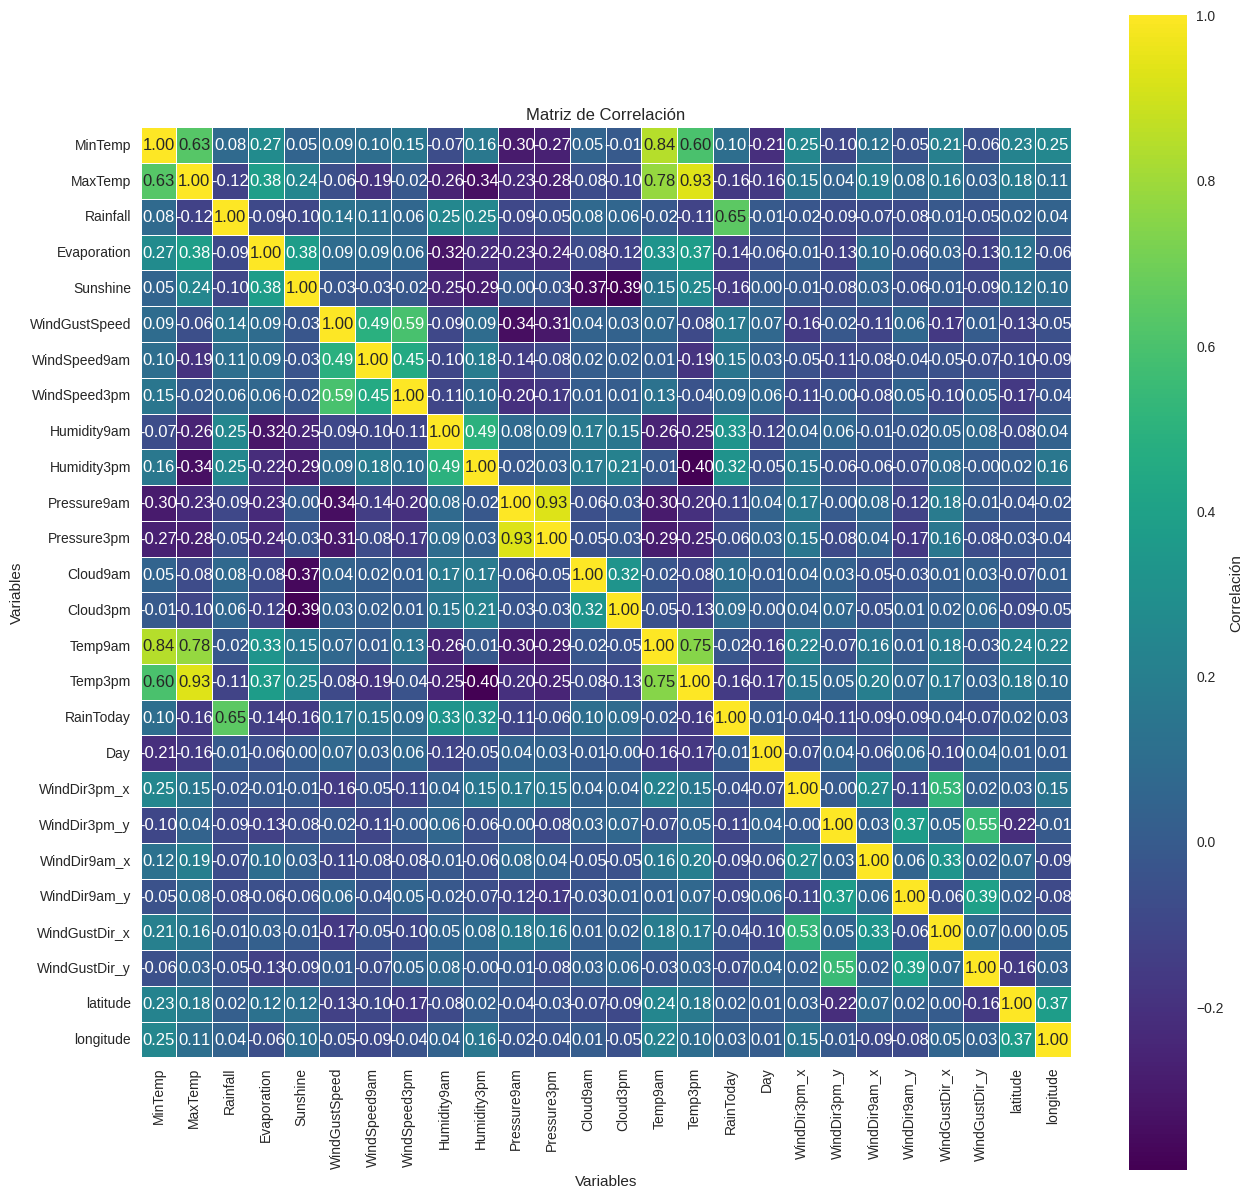

In [47]:
corr_matrix: np.ndarray = X_train_std[columns_sin_anios].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='viridis',
            cbar_kws={'label': 'Correlación'},
            square=True,
            fmt='.2f',
            linewidths=0.5,
            linecolor='white')

plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

plt.show()

Se encuentras correlaciones fuertes, destacando:

- Pressure9am - Pressure3pm
- MinTemp - Temp9am
- MaxTemp - Temp3pm
- MaxTemp - Temp9am
- Temp9am - Temp3pm

Estas correlaciones tienen sentido y reflejan patrones meteorológicos típicos de comportamiento de las variables relacionadas con la temperatura y la presión.


# Implementación de modelos

Dado que el dataset se encuentra altamente desbalanceado, se descarta el uso de Accuracy como metrica.

Por lo que analizará el modelo en base a Precision, recall, F1

En una primera instancia, se analiza el modelo de regresión logistica


### Regresión logística sin balance

In [48]:
# Realizamos esto ya que en el conjunto y_test se codifica en 1 y 0 pero en formato np.float32 y debe ser entero.
y_test = y_test.astype(int)

In [49]:
y_test.isna().count()

,0
RainTomorrow,6040


In [50]:
# definimos funciona para mostrar los resultados
def mostrar_resultados(y_test: np.ndarray, pred_y: np.ndarray, title_: str, grafica: bool = True) -> np.ndarray:
      conf_matrix: np.ndarray = confusion_matrix(y_test, pred_y)

      if grafica:
        fig = px.imshow(conf_matrix,
            text_auto=True,
            title=title_,
            labels={'x':'Predicción', 'y':'Actual'},
            x=['No llueve', 'Llueve'],
            y=['No llueve', 'Llueve'])

        fig.show()

      return conf_matrix


In [51]:
logr_model = LogisticRegression(C=1.0, penalty='l2', random_state=1, solver="newton-cg")
logr_model.fit(X_train_std, y_train)

pred_y: np.ndarray = logr_model.predict(X_test_std)

In [52]:
confusion_matrix_manual_model = mostrar_resultados(y_test,pred_y, 'Matriz de Confusión sin balanceo')
confusion_matrix_manual_model

array([[4372,  276],
       [ 763,  629]])

La precisión general del modelo es bastante alta, pero hay un número significativo de falsos negativos, lo que indica que el modelo podría estar fallando en identificar algunas instancias positivas.
La alta especificidad sugiere que el modelo es efectivo para identificar negativos, mientras que la sensibilidad sugiere que se podría mejorar la identificación de positivos.

In [53]:
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4648
           1       0.70      0.45      0.55      1392

    accuracy                           0.83      6040
   macro avg       0.77      0.70      0.72      6040
weighted avg       0.82      0.83      0.81      6040



In [54]:
y_scores = logr_model.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

In [55]:
auc(fpr, tpr)

0.834528384473856

Cálculo de umbral óptimo por medio de estadística de Youden.

In [56]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

In [57]:
confusion_matrix_manual_model_optimal  = mostrar_resultados(
    y_test,y_pred_optimal,
    'Matriz de Confusión sin balanceo, calculando umbral óptimo')

confusion_matrix_manual_model_optimal

array([[3664,  984],
       [ 381, 1011]])

Si bien con el umbral mejoramos los falsos positivos, la diferencia no es significativa.

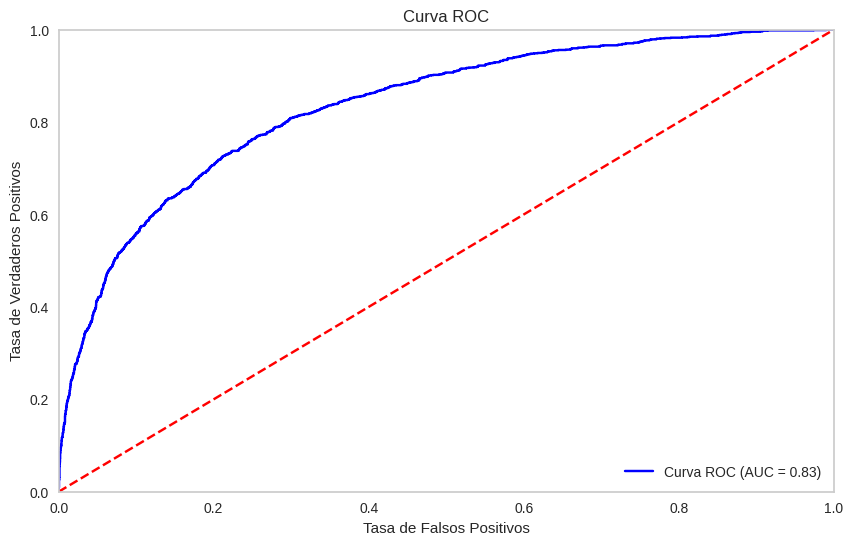

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

La curva ROC con un AUC de 0.84, indica que el modelo es capaz de distinguir correctamente los días en los que **NO llueve** de aquellos en los que sí, con un balance adecuado entre la detección correcta de lluvia y la minimización de falsas alarmas. Aunque no es perfecto, el modelo es bastante preciso en sus predicciones.

Sabiendo también las métricas de recall, f1-score, support sabemos que el modelo tiene un buen desempeño prediciendo cuándo no llueve pero malo con respecto a cuando sí llueve.

In [59]:
logr_model_balanced = LogisticRegression(C=1.0, penalty='l2',class_weight='balanced', random_state=1, solver="newton-cg")
logr_model_balanced.fit(X_train_std, y_train)

pred_y_balanced: np.ndarray = logr_model_balanced.predict(X_test_std)

In [60]:
print(classification_report(y_test, pred_y_balanced))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      4648
           1       0.48      0.76      0.59      1392

    accuracy                           0.76      6040
   macro avg       0.70      0.76      0.71      6040
weighted avg       0.81      0.76      0.77      6040



In [61]:
auc(fpr, tpr)

0.834528384473856

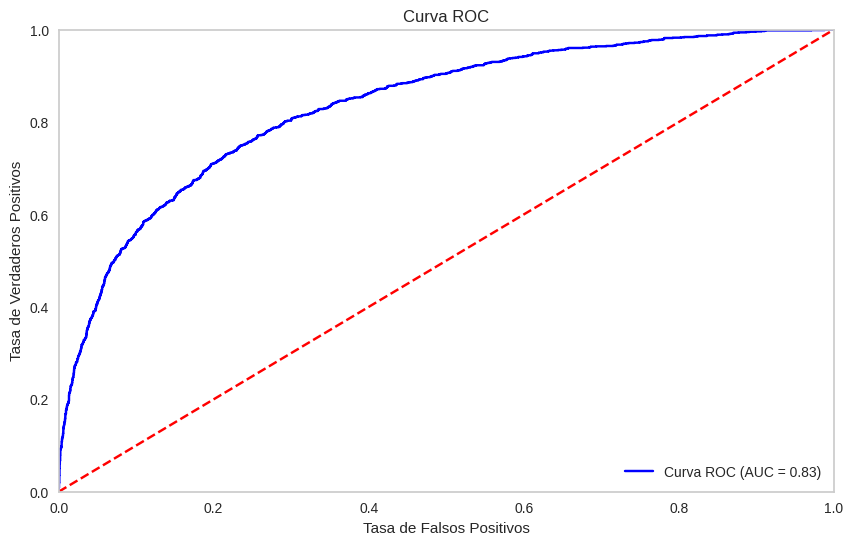

In [62]:
y_scores = logr_model_balanced.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Se hizo una prueba de cambiar los parámetros de la funcion de LogisticRegresion. Si bien la curva es apenas distinta, el AUC es idéntico.

In [63]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

In [64]:
mostrar_resultados(y_test,y_pred_optimal, 'Matriz de Confusión sin balanceo, calculando umbral óptimo V2')

array([[3644, 1004],
       [ 375, 1017]])

La matriz de confusion es exactamente la misma.

## Analisis de 'buen' o 'mal' fitting

El AUC refleja un buen desempeño general del modelo, indicando que predice correctamente en la mayoría de los casos. Sin embargo, hemos identificado que el modelo funciona mejor prediciendo los días en los que no llueve, mientras que muestra deficiencias al predecir los días en los que sí llueve. Este problema probablemente se deba a un desbalance en el conjunto de datos, donde los días sin lluvia podrían estar representados en mayor cantidad que los días con lluvia, lo que lleva al modelo a favorecer la clase mayoritaria.

## Validacion Cruzada
1. Se observa una disminución rápida en la precisión entre los primeros dos folds, lo que es inusual. Esto sugiere que los datos podrían no estar bien equilibrados o que el modelo no es consistente.
2. Las curvas de KFold y StratifiedKFold son casi idénticas, lo que indica que la estratificación no afecta significativamente la precisión en este conjunto de datos.
3. La precisión que cae a cero en el segundo fold sugiere problemas potenciales, como clases desbalanceadas, datos de baja calidad o configuraciones incorrectas en el entrenamiento.

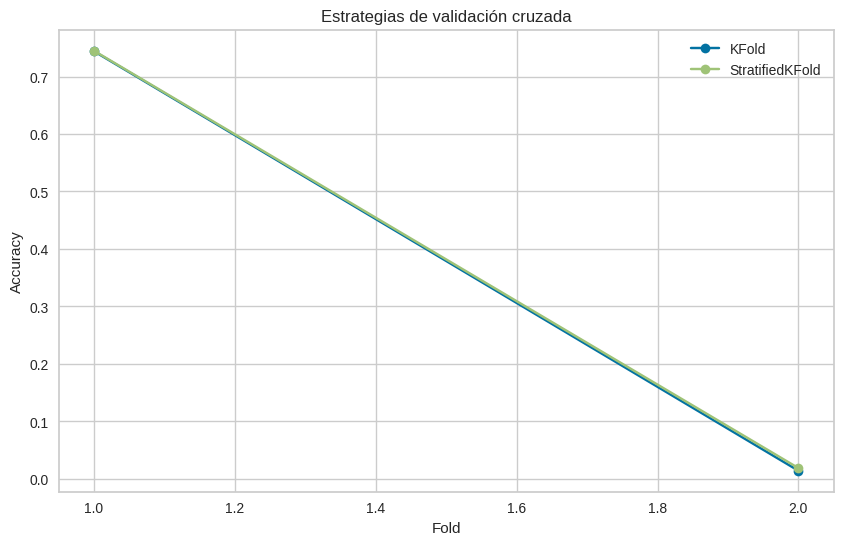

Estrategia: KFold - Media: 0.744, Desvío Estándar: 0.014
Estrategia: StratifiedKFold - Media: 0.745, Desvío Estándar: 0.019


In [65]:
cv_strategies: List[Tuple[str, Any]] = [
    ("KFold", KFold(n_splits=20, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=20, shuffle=True, random_state=42))
]

results: dict = {}

for name, cv in cv_strategies:
    scores = cross_val_score(logr_model_balanced, X_train_std, y_train, cv=cv)
    results[name] = (scores.mean(), scores.std())

plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

for name, (mean, std) in results.items():
    print(f"Estrategia: {name} - Media: {mean:.3f}, Desvío Estándar: {std:.3f}")

# Modelo base

Para esta ocasión elegimos un modelo de regresión lineal con una única variable. Elegimos la columna de 'RainToday' para entrenar el modelo.

In [66]:
lr_model = LinearRegression()
lr_model.fit(X_train_std[['RainToday']], y_train)

lr_y_pred = lr_model.predict(X_test[['RainToday']])


# Evaluar el modelo.
linear_mse: np.float64 = mean_squared_error(y_test, lr_y_pred)
linear_r2: np.float64 = r2_score(y_test, lr_y_pred)

print(f'El error cuadrático medio es: {linear_mse}')
print(f'El r2 score es: {linear_r2}')

El error cuadrático medio es: 0.16854065714494293
El r2 score es: 0.04967269977401145


El análisis de las métricas en este caso es trivial. El error cuadrático medio si bien es bajo, el r2 score tiene un desempeño muy poco deseable. Esto se debe a que no

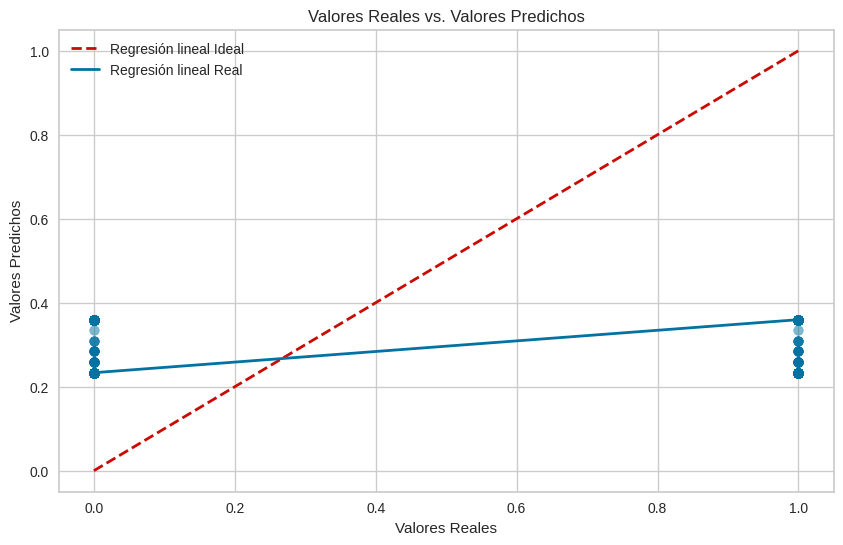

Mean Squared Error: 0.16854065714494293
R^2 Score: 0.04967269977401145


In [67]:
# Grafica de la regresión

plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label = 'Regresión lineal Ideal')
plt.plot([y_test.min(), y_test.max()], [lr_y_pred.min(), lr_y_pred.max()], 'b', lw=2, label = 'Regresión lineal Real')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.legend()
plt.title('Valores Reales vs. Valores Predichos')
plt.show()

print(f'Mean Squared Error: {linear_mse}')
print(f'R^2 Score: {linear_r2}')

Con las métricas del modelo base, podemos compararlo con el modelo de regresión logística. Aunque las métricas no son idénticas, es evidente que el rendimiento del modelo base, que utiliza una regresión logística de una sola variable, es bastante deficiente.

# Optimización de Hiperparámetros

Se arma un diccionario para los parámetros a optimizar. Se utiliza RandomSearchCV para optimizar los parámetros. Este es utilizado debido a que es menos costoso que GridSearchCV.

In [68]:
parametros: dict[str, list[Any]] = {
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'dual':[False, True],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'newton-cg'],
    'max_iter': [50,150,300, 500,1000, 2000,5000]
}

In [69]:
lr_model_randomizedCV = LogisticRegression()

scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'Recall': make_scorer(recall_score, average='weighted')
}

random_search = RandomizedSearchCV(
    estimator=lr_model_randomizedCV,
    param_distributions=parametros,
    n_iter=50,
    scoring=scoring,
    refit='F1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Perform the search
random_search.fit(X_train_std, y_train['RainTomorrow'])

pred_y_randomizedCV = random_search.predict(X_test_std)

# Get the best parameters and scores
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)
print("Best Recall Score:", random_search.cv_results_['mean_test_Recall'][random_search.best_index_])

Best Parameters: {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 5000, 'fit_intercept': False, 'dual': False, 'class_weight': None, 'C': 0.01}
Best F1 Score: 0.7992556493010119
Best Recall Score: 0.8110192837465565


In [70]:
print('Rendimiento de regresión logística con Randomized CV: \n')
print (classification_report(y_test, pred_y_randomizedCV))
print('--------------------------------------------------------------------------------')
print('Rendimiento de regresión logística hecha anteriormente: \n')
print (classification_report(y_test, y_pred_optimal))

Rendimiento de regresión logística con Randomized CV: 

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4648
           1       0.63      0.53      0.58      1392

    accuracy                           0.82      6040
   macro avg       0.75      0.72      0.73      6040
weighted avg       0.81      0.82      0.81      6040

--------------------------------------------------------------------------------
Rendimiento de regresión logística hecha anteriormente: 

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4648
           1       0.50      0.73      0.60      1392

    accuracy                           0.77      6040
   macro avg       0.70      0.76      0.72      6040
weighted avg       0.81      0.77      0.78      6040



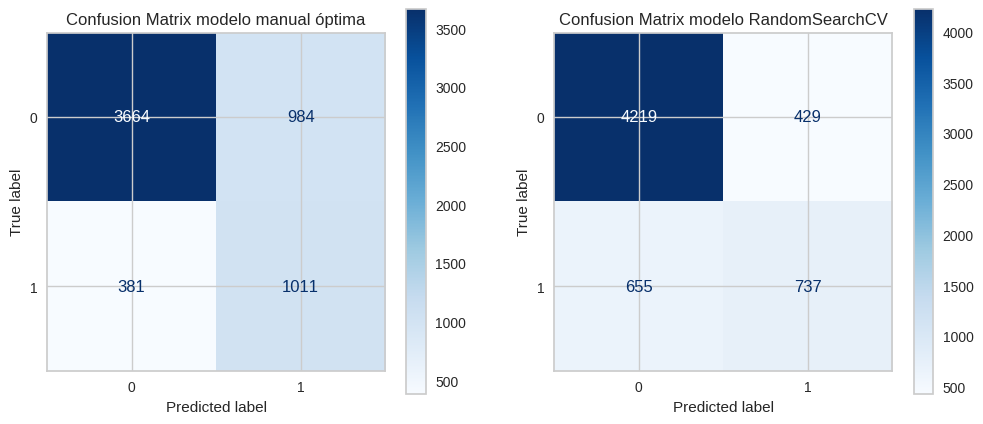

In [71]:
confusion_matrix_random_search = mostrar_resultados(y_test,
                                                    pred_y_randomizedCV,
                                                      'Matriz de confusión de modelo obtenido con RandomSearchCV', grafica=False)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix_manual_model_optimal).plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix modelo manual óptima")

ConfusionMatrixDisplay(confusion_matrix_random_search).plot(ax=ax[1], cmap='Blues')
ax[1].set_title("Confusion Matrix modelo RandomSearchCV")

plt.show()

El modelo realizado a mano con la optimización de Youden  tiene un rendimiento superior en la predicción de días de lluvia en comparación con el modelo ajustado hallado por RandomizedSearchCV. EL Recall en conjunto con el F1-score en la detección de días lluviosos mejora, lo que indica un mejor equilibrio del modelo. El recall para días de lluvia es considerablemente mayor en el modelo optimizado por Youden, la precisión general y el rendimiento equilibrado en ambas clases reflejan un modelo más robusto y confiable.

Esto se ve ilustrado en las matrices de confusión. Vemos que el modelo por RandomSearch acierta muy bien a cuando no llueve pero cuando llueve, el modelo optimizado tiene un rendimiento mucho mejor.

Le atribuimos esto a que los datos están desbalanceados.


# SHAP

In [72]:
shap.initjs()

In [73]:
explainer = shap.Explainer(
    logr_model, X_train_std, feature_names=X_train_std.columns
)
shap_values = explainer(X_test_std)


## Análisis local

In [74]:
# Para el análisis se usará el indice 150
index = 150

In [75]:
y_test.iloc[index]

,154
RainTomorrow,1


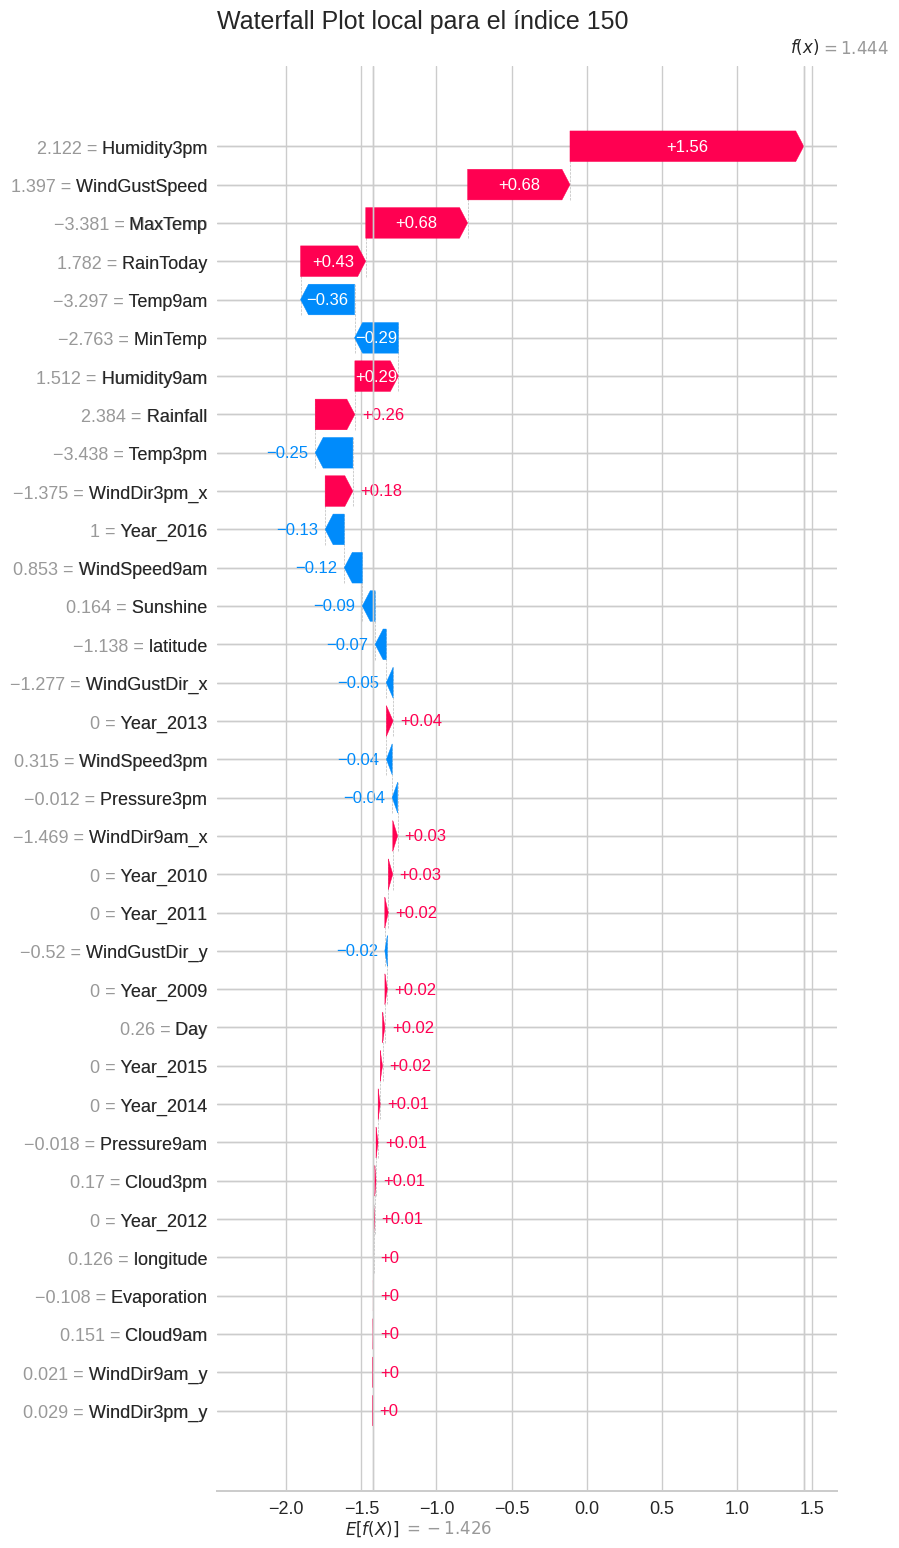

In [76]:
# Waterfall plot

plt.figure()
plt.title(f'Waterfall Plot local para el índice {index}', fontsize = 18, loc='left')
shap.plots.waterfall(shap_values[index], max_display=99, show=False)
plt.show()

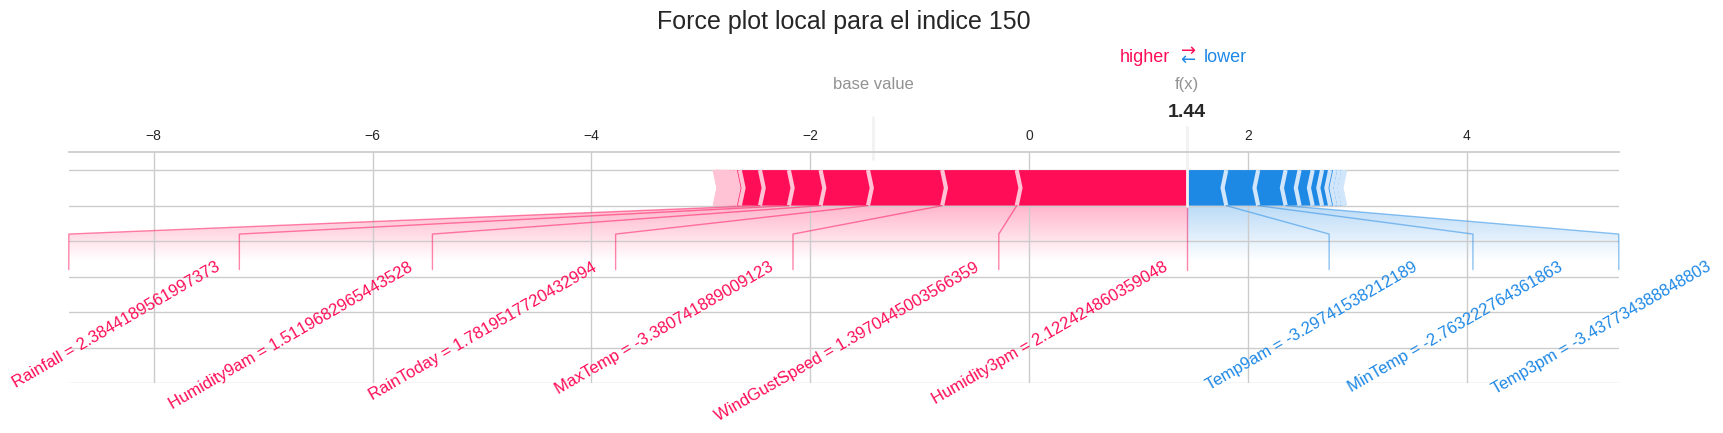

In [77]:
# Force plot
shap.plots.force(shap_values[index],show=False, matplotlib=True, text_rotation= 30)
plt.title(f'Force plot local para el indice {index}', y=1.50, fontsize = 18)
plt.show()

En este caso SHAP determinó significantes a la Humedad a las 3pm, la velocidad del viento, la temperatura máxima registrada a las 3pm y si llovió en el día para la pedicción. Las mismas 'suman' al modelo. Por otro lado, las direcciones *y* del viento a las 3pm y 9pm, la longuitud, evaporación y nubosidad fueron las variables que no aporaron nada significante a la suma.


## Analisis global

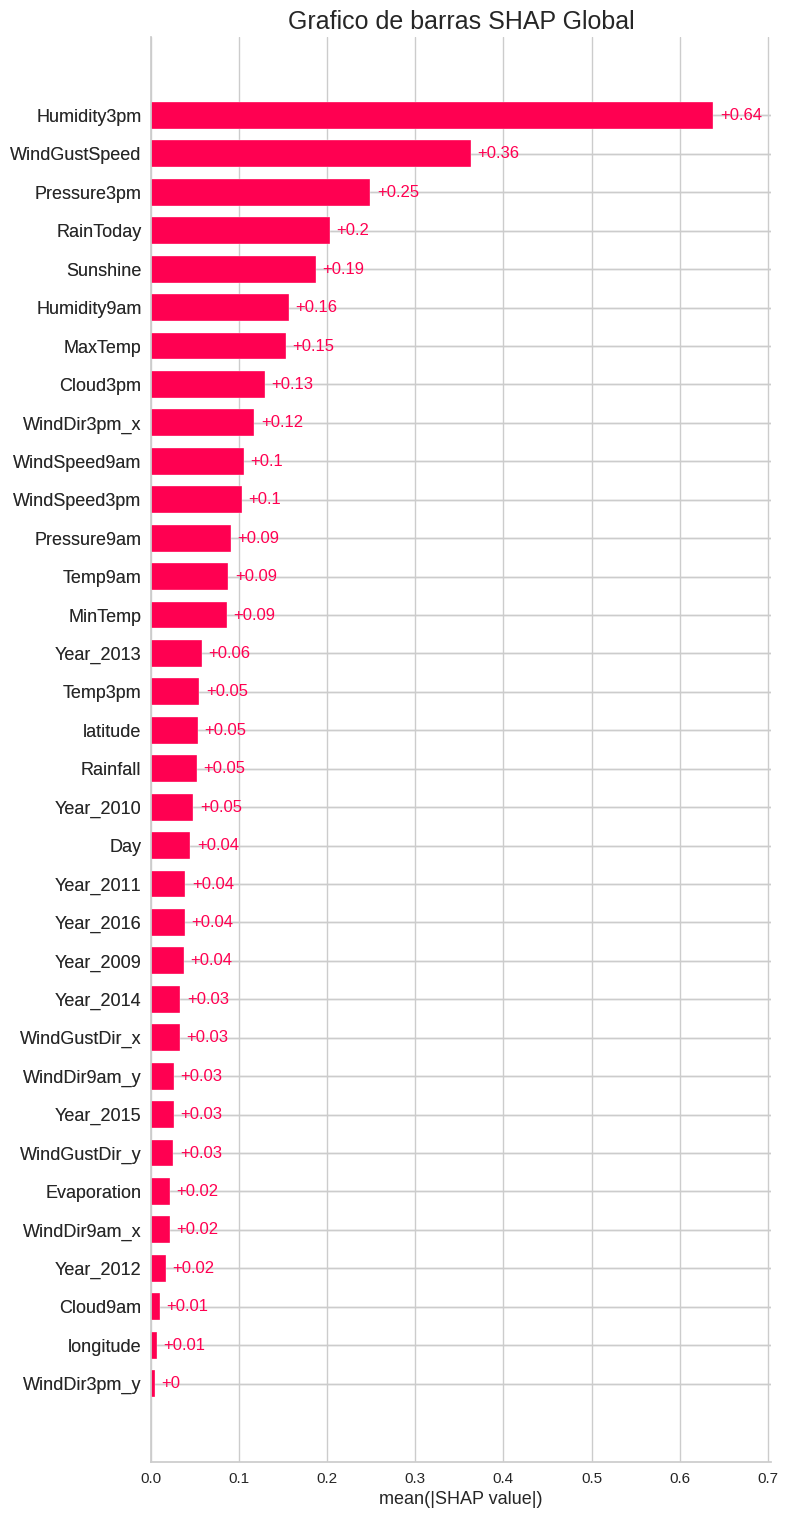

In [78]:
plt.figure()
shap.plots.bar(shap_values, max_display=99, show=False)
plt.title('Grafico de barras SHAP Global', fontsize=18, loc = 'center')
plt.show()

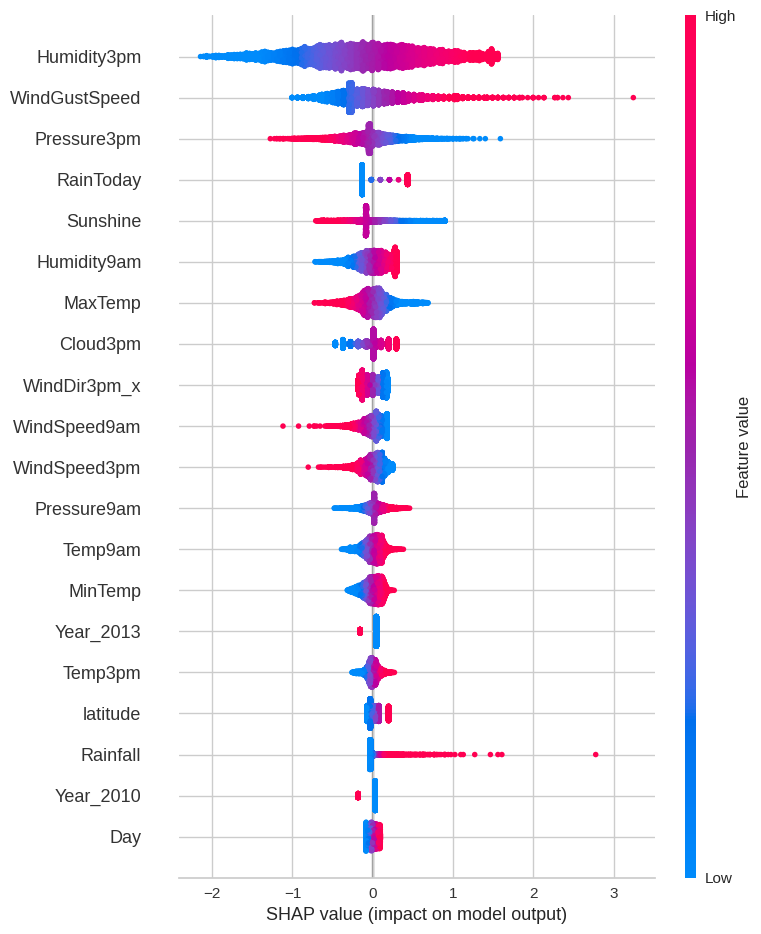

Text(0.5, 1.0, 'Summary plot SHAP Global')

In [79]:
shap.summary_plot(shap_values, X_test_std, plot_type="dot", show=True)
plt.title('Summary plot SHAP Global', fontsize = 18)


A nivel global, SHAP identifica la Humedad, la Presión y la Velocidad del viento como las variables más influyentes. Por el contrario, los años, la evaporación, las direcciones del viento y la ubicación se consideran las menos relevantes.

Notamos que obtuvimos resultados distintos que en el análisis local, como lo puede ser el valor asignado a temperatura máxima registrada en el día. Esto resalta la importancia de combinar ambos enfoques para obtener una visión más completa y precisa del modelo y sus predicciones.

## Conclusiones de SHAP

**Características clave:**
Humidity3pm, WindGustSpeed y Pressure3pm son las más influyentes en el modelo. Esto sugiere que las condiciones de humedad y viento juegan un papel crucial en la tarea de predicción.

**Estrategias futuras:** Se puede considerar estas características para optimizar o simplificar el modelo, ya que parecen tener la mayor influencia en las decisiones del modelo.

# Auto ML

Se implementa Pycaret para la confección de un modelo de auto ml, a fin de comparar con el hecho de forma manual.

Se Dropean las filas que contienen un RainTomorrow nan.

In [80]:
df_pure = df.dropna(subset=['RainTomorrow'])

Inicialización del modelo de auto machine learning. Se setea un session_id para tener siempre el mismo resultado.

In [81]:
auto_ml = setup(df_pure, target='RainTomorrow', session_id=42, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(30243, 28)"
4,Transformed data shape,"(30243, 28)"
5,Transformed train set shape,"(21170, 28)"
6,Transformed test set shape,"(9073, 28)"
7,Numeric features,27
8,Rows with missing values,71.6%
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

Comparamos los modelos para elegir el mejor. Utilizamos 'F1' como métrica de evaluación ya que el dataset está desbalanceado.  

In [82]:
best_model_auto_ml = compare_models(sort='F1')
best_model_auto_ml

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8456,0.8666,0.5408,0.7257,0.6196,0.5253,0.5344,0.5360
lightgbm,Light Gradient Boosting Machine,0.8481,0.8707,0.5252,0.7470,0.6164,0.5253,0.5382,0.4770
rf,Random Forest Classifier,0.8450,0.8655,0.4834,0.7635,0.5917,0.5020,0.5221,4.5600
gbc,Gradient Boosting Classifier,0.8435,0.8573,0.4805,0.7580,0.5878,0.4972,0.5171,6.3870
et,Extra Trees Classifier,0.8441,0.8658,0.4750,0.7657,0.5861,0.4965,0.5181,2.2210
qda,Quadratic Discriminant Analysis,0.8126,0.8242,0.5288,0.6128,0.5675,0.4488,0.4509,0.1260
ada,Ada Boost Classifier,0.8313,0.8359,0.4661,0.7091,0.5621,0.4632,0.4791,1.5850
lda,Linear Discriminant Analysis,0.8262,0.8333,0.4646,0.6868,0.5538,0.4509,0.4644,0.2290
nb,Naive Bayes,0.7929,0.8038,0.5473,0.5557,0.5513,0.4167,0.4168,0.0630
knn,K Neighbors Classifier,0.8244,0.7929,0.4571,0.6827,0.5474,0.4438,0.4576,0.6320


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

Creamos el modelo de autoML

In [83]:
auto_ml_model = create_model(best_model_auto_ml)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8526,0.8631,0.5508,0.7486,0.6347,0.5450,0.5551
1,0.8399,0.8653,0.5407,0.7018,0.6108,0.5121,0.5190
2,0.8366,0.8554,0.5203,0.6995,0.5967,0.4970,0.5056
3,0.8526,0.8698,0.5772,0.7320,0.6455,0.5541,0.5603
4,0.8441,0.8597,0.5203,0.7314,0.6081,0.5142,0.5258
5,0.8460,0.8751,0.5528,0.7196,0.6253,0.5305,0.5378
6,0.8465,0.8712,0.5558,0.7211,0.6277,0.5331,0.5402
7,0.8427,0.8636,0.5233,0.7247,0.6078,0.5126,0.5232
8,0.8498,0.8735,0.5294,0.7522,0.6214,0.5312,0.5440


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Optimizamos F1, métrica que utilizaremos para comparar este modelo generado por AutoML con el modelo hecho de forma manual con el óptimo.

In [84]:
tuned_model = tune_model(auto_ml_model, n_iter=10, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7898,0.8705,0.7703,0.5331,0.6301,0.4900,0.5062
1,0.8002,0.8696,0.7663,0.5504,0.6406,0.5073,0.5207
2,0.7818,0.8564,0.7581,0.5209,0.6175,0.4721,0.4884
3,0.7931,0.8675,0.7581,0.5390,0.6301,0.4921,0.5059
4,0.7936,0.8650,0.7744,0.5389,0.6355,0.4979,0.5138
5,0.7879,0.8666,0.7703,0.5301,0.6280,0.4867,0.5033
6,0.7997,0.8730,0.7769,0.5495,0.6437,0.5100,0.5248
7,0.7931,0.8632,0.7627,0.5395,0.6319,0.4939,0.5082
8,0.7955,0.8693,0.7708,0.5429,0.6370,0.5006,0.5155


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Teniendo en cuenta las métricas obtenidas con la optimización de Youden anteriormente, observamos que el rendimiento es inferior.

Esto se debe a que el pre procesado de los datos está hecho de forma automática, sin tener en cuenta cuestiones específicas del problema como lo hemos logrado mediante la interpretación de cada una de las columnas.

Si miramos F1-score para cada modelo:
- F1-score modelo manual con opt. de Youden: 0.77.
- F1-score para modelo de Auto ML: 0.63 (media).

También, cabe destacar que los modelos son distintos. AutoML situa a XGBClassifier como su mejor opción, mientras que la Regresión Logística alcanzada por este mismo algoritmo tiene un rendimiento con un F1-score inferior (0.55).

# Balanceo de datos
Se utiliza ADASYN, por una cuestión que prioriza los datos que son más difíciles de clasificar.


In [113]:
adasyn: ADASYN = ADASYN(sampling_strategy = 'minority', random_state=42)

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_std, y_train)

Visualizamos el constraste entre los datos balanceados y desbalanceados

In [114]:
y_train_resampled.value_counts()

,count
RainTomorrow,
0.0,16697
1.0,16539


In [115]:
y_train.value_counts()

,count
RainTomorrow,
0.0,16697
1.0,5083


Para evaluarlo de forma rápida, hago una regresión logística con los parámetros obtenidos de hacer RandomizedCV.

In [121]:
lr_balanced = LogisticRegression(tol = 0.0001, solver = 'liblinear', penalty = 'l2', fit_intercept = False, dual = False, C = 0.01)

lr_balanced.fit(X_train_resampled, y_train_resampled)

y_pred_lr_balanced = lr_balanced.predict(X_test_std)

In [122]:
print('Nuevo reporte con dataset balanceado:')
print(classification_report(y_test, y_pred_lr_balanced))
print('------------------------------------------------------')
print('Reporte con dataset desbalanceado:')
print(classification_report(y_test, y_pred_optimal))

Nuevo reporte con dataset balanceado:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      4648
           1       0.45      0.79      0.58      1392

    accuracy                           0.73      6040
   macro avg       0.69      0.75      0.69      6040
weighted avg       0.81      0.73      0.75      6040

------------------------------------------------------
Reporte con dataset desbalanceado:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4648
           1       0.50      0.73      0.60      1392

    accuracy                           0.77      6040
   macro avg       0.70      0.76      0.72      6040
weighted avg       0.81      0.77      0.78      6040



Hay una mejora sobre las predicciones de los días de lluvia (1). Esta mejoría es a costa de desmejorar el recall de los días que no lleuven.

In [112]:
mostrar_resultados(y_test, y_pred_lr_balanced, 'Matriz de confusión de modelo con datos balanceados', True)
mostrar_resultados(y_test, y_pred_optimal, 'Matriz de confusión de modelo con datos desbalanceados', True)

array([[3644, 1004],
       [ 375, 1017]])

# Redes Neuronales

In [132]:
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        #inicializo algunos parámetros como épocas, batch_size, learning rate
        #(no son necesarios)
        #se puede agregar la cantidad de capas, la cantidad de neuronas por capa (pensando en hacer una clase que pueda ser usada para cualquier caso)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape, num_classes):
        # ejemplo con 2 capas ocultas de 64 neuronas y activación softmax (multiclase, recibe la cantidad de clases como input, además del input_shape)
        model = tf.keras.models.Sequential([
            #tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(input_shape,)),
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(26, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

        #compilo el modelo con el optimizador Adam, la función de pérdida categorical_crossentropy y la métrica accuracy
        #totalmente optimizable e incluso pueden ser parámetros de la función build_model

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        # simplemente el fit del modelo. Devuelvo la evolución de la función de pérdida, ya que es interesante ver como varía a medida que aumentan las épocas!
        history=self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=self.epochs, batch_size=self.batch_size)
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        ### evalúo en test
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"test accuracy: {accuracy:.4f}")

    def predict(self, X_new):
        ### predicciones
        predictions = self.model.predict(X_new)
        return predictions


    ### acá también me podría armar una función para graficar la evolución de la función de pérdida en train y validación, etc etc

In [133]:
nn_model = NeuralNetwork(epochs=100, batch_size=16, learning_rate=0.1)

nn_model.build_model(input_shape=X_train_std.shape[1], num_classes=y_train.shape[1])
history_imb = nn_model.train(X_train_std, y_train, X_test_std, y_test)

nn_model.evaluate(X_test_std, y_test)


Epoch 1/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7680 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 2/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7669 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 3/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7644 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 4/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7726 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 5/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7648 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 6/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7710 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 7/100
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7686 - loss: 0.0000e+00 - val_accuracy: 0.7695 - val_loss: 0.0000e+00
Epoch 8/100
1362/1362 ━━━━